# Pixel to Metric Conversion

When I take an image that contains an object, then I measure the size of it, I need to do conversion from pixel units into metric units.

output img


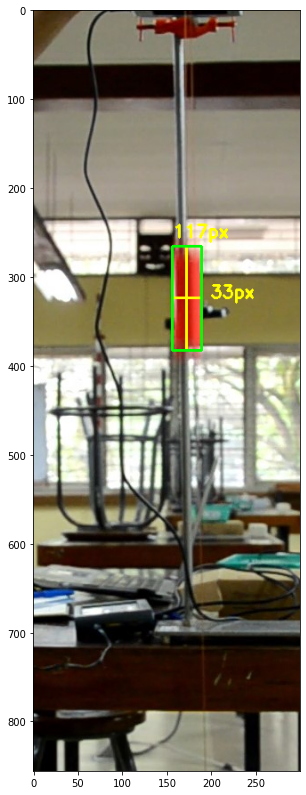

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from scipy.spatial import distance as dist

def reorder_box(pts):
	xSorted = pts[np.argsort(pts[:, 0]), :]
	leftMost = xSorted[:2, :]
	rightMost = xSorted[2:, :]
	leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
	(tl, bl) = leftMost
	D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
	(br, tr) = rightMost[np.argsort(D)[::-1], :]
	return np.array([tl, tr, br, bl])

def get_boxes(cnts):
    boxes = []      # array to store box for every contour
    for cnt in cnts:
        rect = cv.minAreaRect(cnt)
        box = cv.boxPoints(rect)
        box = np.int0(box)
        box = reorder_box(box)      # reorder 4 points in box
        boxes.append(box)
    return boxes

def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def draw_centreline_box(frame, boxes, color=(0,255,255), thickness=2, ppm=None):
    for box in boxes:
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        cv.line(frame, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), color, thickness)
        cv.line(frame, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), color, thickness)

        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

        # compute the size of the object
        # dimA = dA / ppm     # pixel per metric
        # dimB = dB / ppm

        # draw the object sizes on the image
        cv.putText(frame, "{:.0f}px".format(dA),
		(int(tltrX - 15), int(tltrY - 10)), cv.FONT_HERSHEY_SIMPLEX, 0.65, color, thickness)
        cv.putText(frame, "{:.0f}px".format(dB),
		(int(trbrX + 10), int(trbrY)), cv.FONT_HERSHEY_SIMPLEX, 0.65, color, thickness)

    return frame

def get_euclidian_distance(pt1=[0,0], pt2=[0,0]):
    dx = pt2[0] - pt1[0]
    dy = pt2[1] - pt1[1]
    dist = sqrt(dx**2 + dy**2)
    return dist

def get_box_size(cnts):
    w = get_euclidian_distance(cnts[0][0], cnts[0][1])
    h = get_euclidian_distance(cnts[0][1], cnts[0][2])
    return w, h

def get_conversion_constant(cnts, method=0):
    if method == 0:
        w_real = 2.6 * 10     # object's width in mm
        w_px, h_px = get_box_size(cnts)
        constant = w_real / w_px    # conversion constant to metric unit
    return constant

def processing_frame(frame):
    # h, w, c = frame.shape
    roi = img[:, 800:1100]
    hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
    imgaus = cv.GaussianBlur(hsv, ksize=(7,7), sigmaX=0, sigmaY=0)
    mask = cv.inRange(imgaus, (0,127,150), (9,255,255))     # h<=179; s,v <=255
    edge = cv.Canny(mask, 0, 255)

    cnts, hierarchy = cv.findContours(edge, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if len(cnts) > 1:
        cnts = sorted(cnts, key=cv.contourArea, reverse=True)
        cnts = tuple( [cnts[0]] )   # the biggest one

    boxes = get_boxes(cnts)
    draw_centreline_box(roi, boxes)
    cv.drawContours(roi, boxes, -1, (0,255,0), 2)
    return roi, cnts

if __name__ == "__main__":
    path = "../media/obj_track.jpg"
    img = cv.imread(path)   # if i show the img using matplotlib, BLUE and READ channel need to be swapped
    
    out, cnts = processing_frame(img)


    plt.rcParams['figure.figsize'] = (14, 14)
    # print("img"); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.show()
    # print("roi"); plt.imshow(cv.cvtColor(roi, cv.COLOR_BGR2RGB)); plt.show()
    # print("hsv"); plt.imshow(cv.cvtColor(hsv, cv.COLOR_BGR2RGB)); plt.show()
    # print("imgaus");plt.imshow(cv.cvtColor(imgaus, cv.COLOR_BGR2RGB)); plt.show()
    # print("color mask");plt.imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB)); plt.show()
    # print("canny edge");plt.imshow(cv.cvtColor(edge, cv.COLOR_BGR2RGB)); plt.show()
    print("output img");plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB)); plt.show()